
## Trial to combine middle ear and bruxism tagging to identify pure moments of middle ear activation

In [1]:
import os
PATH = os.getcwd() 
import sys
sys.path.append(PATH + '/../')
import mne
from tinnsleep.config import Config
from tinnsleep.create_reports import preprocess, reporting, combine_brux_MEMA
from tinnsleep.data import CreateRaw, RawToEpochs_sliding, CleanAnnotations, AnnotateRaw_sliding
from tinnsleep.classification import AmplitudeThresholding
from tinnsleep.check_impedance import create_annotation_mne, Impedance_thresholding_sliding, check_RMS, fuse_with_classif_result
from tinnsleep.signal import rms
from tinnsleep.scoring import classif_to_burst, burst_to_episode, create_list_events, generate_bruxism_report, generate_MEMA_report
import warnings
import matplotlib.pyplot as plt
%matplotlib qt
import numpy as np
import pandas as pd
import pickle
import scipy
from tinnsleep.config import Config

print("Config loaded")


Config loaded


## Setting down parameters for MEMA detection

In [32]:
#Setting MEMA parameters
EDF_list = Config.bruxisme_files
THR_classif_MEMA=[[0,3.5]]
sfreq = 250.0
window_length_MEMA = 1.00                    # in seconds
duration_MEMA = int(window_length_MEMA * sfreq)   # in samples
interval_MEMA = duration_MEMA                  # no overlapping
n_adaptive_MEMA = -60/window_length_MEMA          # number of epochs for adaptive baseline
delim_MEMA = 3                               # maximal time interval between bursts to merge episode in seconds

# Dictionnary of known names of the Airflow
mapping = {"Airflow": "MEMA"}
print("MEMA parameters set")
min_burst_joining_MEMA = 0

mema_files = pd.read_csv("data/mema_files.csv",engine='python', sep="; ")["files_with_mema"].values
print(mema_files[:3])

MEMA parameters set
['1DA15_nuit_son.edf' '1GB19_nuit_hab.edf' '1MF19_nuit_hab.edf']


## Setting down parameters for bruxism detection

In [33]:
#Setting parameters
os.chdir("C:/Users/Zeta/Documents/acou_sommeil_HD_ENS/Tinnitus-n-Sleep/Notebooks")
THR_classif_brux=[[0,2]]
sfreq = 250
window_length_brux = 0.25                    # in seconds
duration_brux = int(window_length_brux * sfreq)   # in samples
interval_brux = duration_brux                     # no overlapping
n_adaptive_brux = 480 # number of epochs for adaptative baseline

#Importing personnalized parameters for dataset
df = pd.read_pickle("data/valid_chans_THR_imp.pk")
dico_chans= df.to_dict("list")
min_burst_joining_brux = 3
delim_brux =3
print("Bruxism parameters set")


Bruxism parameters set


In [38]:
%matplotlib inline

## Bruxism + MEMA processing for pure MEMA visualisation

Files processed : 
1BA07_nuit_hab.edf not included
1BA07_nuit_son.edf not included
1CC05_nuit_hab.edf not included
1CC05_nuit_son.edf not included
1DA15_nuit_hab.edf not included
1DA15_nuit_son.edf 1DA15_nuit_son.edf preprocess... DONE (21.82s) report... bruxsim processing DONE (15.75s)
preprocess...DONE (4.03s) report...Mema processing DONE (6.38s)
rapport d'activité : 
nb episodes bruxisme combinés : 
14
Nb épisodes bruxisme purs : 
133
nb episodes MEMA combinés : 
16
Nb épisodes MEMA purs : 
6
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
1.9253359310087959
Nb épisodes bruxisme purs : 
18.29069134458356
nb episodes MEMA combinés : 
2.2003839211529095
Nb épisodes MEMA purs : 
0.8251439704323411
1DL12_nuit_hab.edf not included
1DL12_nuit_son.edf not included
1GB18_nuit_son.edf not included
1GB19_nuit_hab.edf 1GB19_nuit_hab.edf preprocess... DONE (16.01s) report... bruxsim processing DONE (12.68s)
preprocess...DONE (4.23s) report...Mema processing DONE (5.62s)
rap

rapport d'activité : 
nb episodes bruxisme combinés : 
257
Nb épisodes bruxisme purs : 
60
nb episodes MEMA combinés : 
464
Nb épisodes MEMA purs : 
106
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
30.400959476887945
Nb épisodes bruxisme purs : 
7.09750026697773
nb episodes MEMA combinés : 
54.88733539796111
Nb épisodes MEMA purs : 
12.538917138327323
jon_mema.edf jon_mema.edf preprocess... DONE (21.57s) report... bruxsim processing DONE (20.76s)
preprocess...DONE (4.25s) report...Mema processing DONE (10.90s)
rapport d'activité : 
nb episodes bruxisme combinés : 
74
Nb épisodes bruxisme purs : 
74
nb episodes MEMA combinés : 
119
Nb épisodes MEMA purs : 
69
rapport d'activité taux horaire : 
nb episodes bruxisme combinés : 
7.846486900431499
Nb épisodes bruxisme purs : 
7.846486900431499
nb episodes MEMA combinés : 
12.61799920474795
Nb épisodes MEMA purs : 
7.316318866618559
jose_mema.edf jose_mema.edf preprocess... DONE (11.44s) report... bruxsim processing DO

C:\Users\Zeta\Anaconda3\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Users\Zeta\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


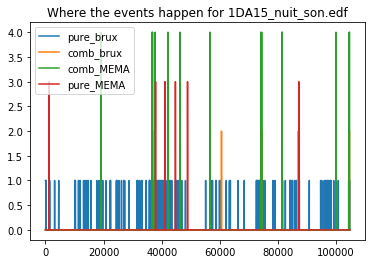

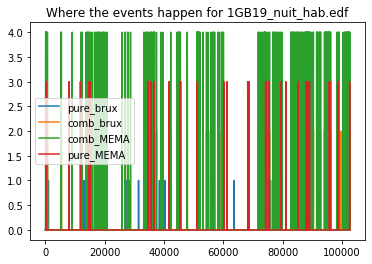

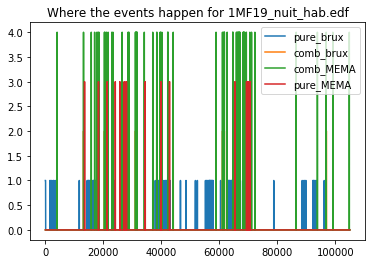

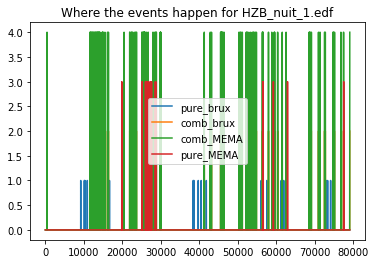

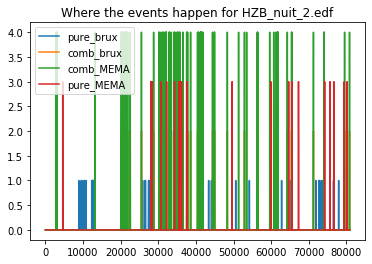

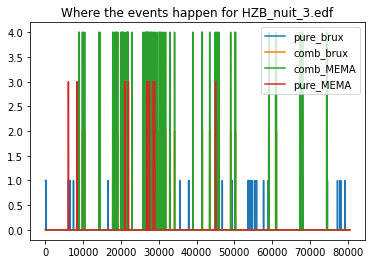

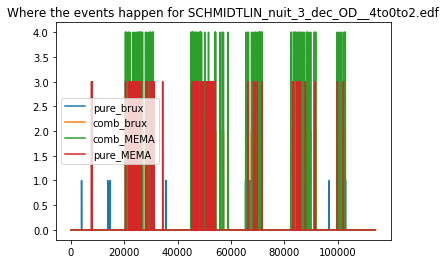

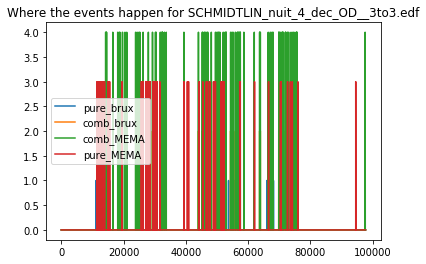

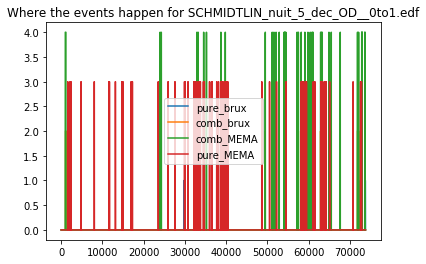

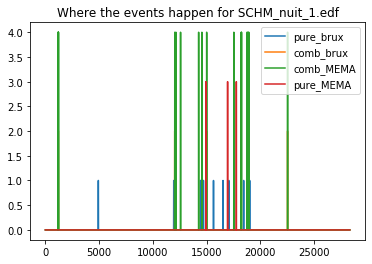

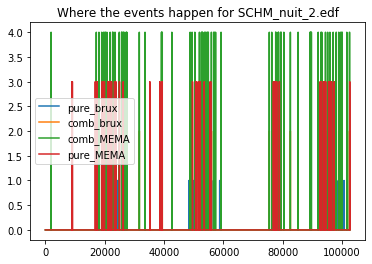

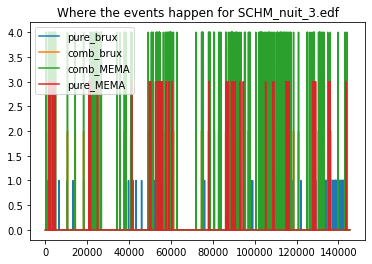

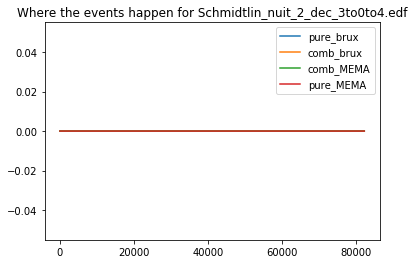

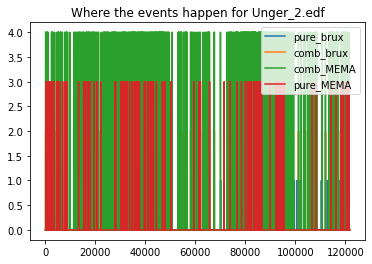

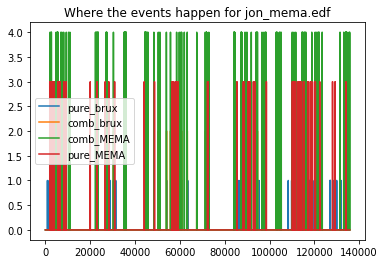

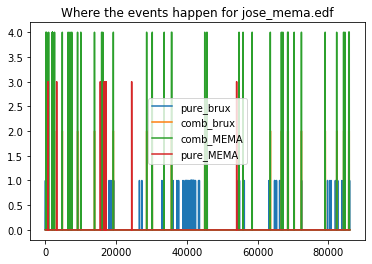

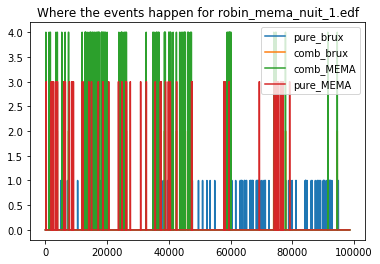

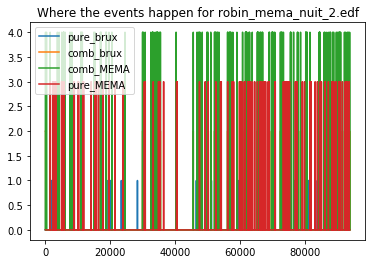

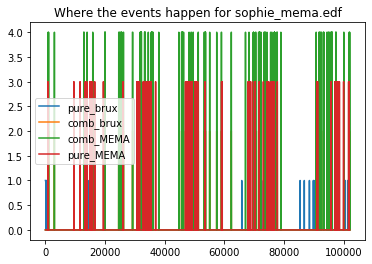

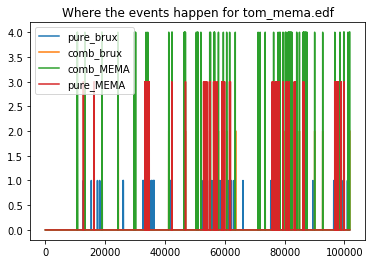

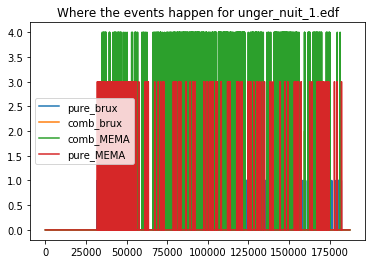

In [40]:
from time import time
# load file from config
#filenames=['E:/Acou_sommeil/EDF_V2_PAUL\\sophie_mema.edf']
filenames = EDF_list

#Output of the processing, stock pure MEMA analysis output

results_MEMA={}
results_brux={}

start = time()

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    print("Files processed : ")
    
    #Loop on all the patient files
    for filename in filenames:
        #opens the raw file
        file = filename.split(os.path.sep)[-1]
        print(file, end=" ")
        if not file in mema_files:
            print(f"not included")
        else:
            #opens the raw file
            raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
            raw.rename_channels(mapping=mapping)
            file = filename.split(os.path.sep)[-1]
            print(file, end=" ")
            #Get channels indexes
            ind_picks_chan= dico_chans[file][0]
            ind_picks_imp= dico_chans[file][1]
            #Get THR_imp value for filename
            THR_imp = dico_chans[file][2]

            #Get channel names from indexes
            if len(ind_picks_chan)>0: #ignore file if no channel is good
                picks_chan=[]
                for elm in ind_picks_chan:
                    picks_chan.append(raw.info["ch_names"][elm])
                picks_imp=[]
                for elm in ind_picks_imp:
                    picks_imp.append(raw.info["ch_names"][elm])
                #Setting parameters for is_good
                params = dict(ch_names=picks_chan,
                      rejection_thresholds=dict(emg=5e-04),  # two order of magnitude higher q0.01
                      flat_thresholds=dict(emg=1e-09),  # one order of magnitude lower median
                      channel_type_idx=dict(emg=[ i for i in range(len(picks_chan))]),
                      full_report=True
                      )
                # Get the preprocessing steps done
                print("preprocess...", end=" ");tmp = time()
                epochs, valid_labels_brux, log = preprocess(raw, picks_chan, picks_imp, duration_brux, interval_brux, params, THR_imp=THR_imp, get_log=True)
                print(f"DONE ({time()-tmp:.2f}s)", end=" ")
                #If at least one epoch is good create report
                print("report...", end=" ");tmp = time()
                if np.sum(valid_labels_brux)>0 :
                    results_brux[filename] = reporting(epochs, valid_labels_brux, THR_classif_brux, time_interval=window_length_brux, delim=delim_brux, n_adaptive = n_adaptive_brux, log=log, generate_report=generate_bruxism_report)
                    print(f"bruxsim processing DONE ({time()-tmp:.2f}s)")
                    
                     
                   
                    

                    picks_chan_user= ['MEMA']  # could be remplaced by an user-specific list loaded from .pk
                    ch_types = "misc"
                    #check if channels exists
                    picks_chan = [];[picks_chan.append(ch) for ch in picks_chan_user if ch in raw.info["ch_names"]]

                    #Get channel names from indexes
                    if len(picks_chan)>0: #ignore file if no channel is good

                        #-----------------MEMA processing preparation ---------------------------------------
                        print("preprocess...", end="");tmp = time()
                        raw = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types=ch_types)  # pick channels and load
                        epochs = RawToEpochs_sliding(raw, duration=duration_MEMA, interval=interval_MEMA, picks=picks_chan)
                        print(f"DONE ({time()-tmp:.2f}s)", end=" ")
                        valid_labels_MEMA = [True] * epochs.shape[0] # consider all valid epochs
                        print("report...", end="");tmp = time()
                        results_MEMA[filename] = reporting(epochs, valid_labels_MEMA, THR_classif_MEMA, time_interval=window_length_MEMA, delim=delim_MEMA, n_adaptive=n_adaptive_MEMA, generate_report=generate_MEMA_report)
                        print(f"Mema processing DONE ({time()-tmp:.2f}s)")
                       
                        
                        


                        brux_comb_ep, brux_pure_ep, compt_arti_brux, MEMA_comb_ep, MEMA_pure_ep, compt_arti_MEMA = combine_brux_MEMA \
                        (results_brux[filename]["labels"][0], valid_labels_brux, window_length_brux, delim_brux, results_MEMA[filename]["labels"][0],
                         valid_labels_MEMA,
                         window_length_MEMA, delim_MEMA,
                         min_burst_joining_brux=0, min_burst_joining_MEMA=0)

                        pure_brux_bursts = classif_to_burst(brux_pure_ep, time_interval=window_length_brux)
                        li_ep_brux_p = burst_to_episode(pure_brux_bursts, delim=delim_brux, min_burst_joining= min_burst_joining_brux)
                        pure_brux_events = create_list_events(li_ep_brux_p, window_length_brux, len(brux_pure_ep) * window_length_brux)

                        comb_brux_bursts = classif_to_burst(brux_comb_ep, time_interval=window_length_brux)
                        li_ep_brux_c = burst_to_episode(comb_brux_bursts, delim=delim_brux, min_burst_joining= min_burst_joining_brux)
                        comb_brux_events = create_list_events(li_ep_brux_c, window_length_brux, len(brux_comb_ep) * window_length_brux)
                        
                        comb_MEMA_bursts = classif_to_burst(MEMA_comb_ep, time_interval=window_length_brux)
                        
                        pure_MEMA_bursts = classif_to_burst(MEMA_pure_ep, time_interval=window_length_brux)
                        
                        print("rapport d'activité : ")
                        print("nb episodes bruxisme combinés : ")
                        print(len(li_ep_brux_c))
                        print("Nb épisodes bruxisme purs : ")
                        print(len(li_ep_brux_p))
                        print("nb episodes MEMA combinés : ")
                        print(len(comb_MEMA_bursts))
                        print("Nb épisodes MEMA purs : ")
                        print(len(pure_MEMA_bursts))
                        
                        print("rapport d'activité taux horaire : ")
                        print("nb episodes bruxisme combinés : ")
                        print(len(li_ep_brux_c)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                        print("Nb épisodes bruxisme purs : ")
                        print(len(li_ep_brux_p)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                        print("nb episodes MEMA combinés : ")
                        print(len(comb_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                        print("Nb épisodes MEMA purs : ")
                        print(len(pure_MEMA_bursts)/ ((len(MEMA_pure_ep)*window_length_brux)/3600))
                        
                        for i in range(len(MEMA_comb_ep)):
                            if MEMA_comb_ep[i]>0:
                                MEMA_comb_ep[i]+=3
                        
                        for i in range(len(MEMA_pure_ep)):
                            if MEMA_pure_ep[i]>0:
                                MEMA_pure_ep[i]+=2
                                
                        for i in range(len(comb_brux_events)):
                            if comb_brux_events[i]>0:
                                comb_brux_events[i]+=1
                                
                        plt.figure()
                        plt.plot(pure_brux_events, label="pure_brux")
                        plt.plot(comb_brux_events, label="comb_brux")
                        plt.plot(MEMA_comb_ep, label="comb_MEMA")
                        plt.plot(MEMA_pure_ep, label="pure_MEMA")
                        plt.legend()
                        plt.title("Where the events happen for " + file)
                        
                       

In [ ]:
         
                        #-----------------Pure MEMA episodes visualisation and comparison with ATM activity -----------------------------------
                        #Preparing raw for visualisation
                        picks_chan = ['Airflow', '1', '2']           # subset of EMG electrodes
                        raw  = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
                        raw  = CreateRaw(raw[picks_chan][0], raw.info["sfreq"], picks_chan, ch_types='emg')        # pick channels and load
                        raw  = raw.load_data()
                        dat=raw.get_data()
                        dat[1]=[dat[1][i]*1/(0.0005) for i in range(len(dat[1]))]
                        dat[2]=[dat[2][i]*1/(0.0005) for i in range(len(dat[2]))]
                        raw  = CreateRaw(dat, raw.info["sfreq"], picks_chan, ch_types='emg') 

                        raw  = raw.filter(20., 99., n_jobs=4, 
                                          fir_design='firwin', filter_length='auto', phase='zero-double',
                                          picks=['1', '2'])

                        #Annotating the raw
                        raw = CleanAnnotations(raw)
                        dict_annotations = {1: "b_pure", 2:"b_comb", 3:"M_pure", 4:"M_comb"}
                        raw = AnnotateRaw_sliding(raw, MEMA_comb_ep , 
                                        dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)

                        raw = AnnotateRaw_sliding(raw, comb_brux_events , 
                                        dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)
                        raw = AnnotateRaw_sliding(raw, pure_brux_events , 
                                        dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)
                        raw = AnnotateRaw_sliding(raw, MEMA_pure_ep , 
                                        dict_annotations=dict_annotations, duration=duration_brux, interval=interval_brux)
                        print("Raw annotated")
                        raw.plot(scalings = "auto")
                        plt.title(filename)

                        



## Small function to check if all channel selections are good

In [5]:
import warnings

labels_subj={}
EDF_list = Config.bruxisme_files

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    
    results={}
    print("Files processed : ")
    for filename in EDF_list:
        #opens the raw file
        raw = mne.io.read_raw_edf(filename, preload=False, verbose=False)  # prepare loading
        print(filename.split("\\")[-1])
        #Get channels indexes
        ind_picks_chan= dico_chans[filename.split("\\")[-1]][0]
        ind_picks_imp= dico_chans[filename.split("\\")[-1]][1]
        #Get THR_imp value for filename
        THR_imp = dico_chans[filename.split("\\")[-1]][2]
        #print(raw.info["ch_names"])
        #Get channel names from indexes
        if len(ind_picks_chan)>0: #ignore file if no channel is good
            picks_chan=[]
            for elm in ind_picks_chan:
                picks_chan.append(raw.info["ch_names"][elm])
            picks_imp=[]
            for elm in ind_picks_imp:
                picks_imp.append(raw.info["ch_names"][elm])
            print(picks_chan)
            print(picks_imp)
            print("")

Files processed : 
1BA07_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1BA07_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1CC05_nuit_hab.edf
['1', '2']
['1 Impedance', '2 Impedance']

1CC05_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1DA15_nuit_hab.edf
['1']
['1 Imp?dance']

1DA15_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1DL12_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1DL12_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1GB18_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1GB19_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1GF14_nuit_hab.edf
1GF14_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1MA16_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1MA16_nuit_son.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1MF19_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp?dance']

1MF19_nuit_son.edf
['1', '2']
['1 Impedance', '2 Impedance']

1MN09_nuit_hab.edf
['1', '2']
['1 Imp?dance', '2 Imp